# Tree Similarity Approach

In [2]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import zss    #pip install zss
import xml.etree.ElementTree as ET
import os
import copy
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering

In [13]:
def get_children(node):
    my_children = [child for child in node]
    return my_children

    
def get_label(node):
    my_label = [child.tag for child in node]
    return my_label

def xmltree_dist(root_1,root_2):
    if root_1==root_2:
        return 0.0
    else:
        d  = zss.simple_distance(root_1,root_2,get_children,get_label)
    return d

    
def xml_parser(path_cpp,path_xml):
    for f in os.listdir(path_cpp):
        fname = f.replace('.cpp','.xml')
        print(fname)
        source_file = path_cpp+str(f)
        dest_file = path_xml+str(fname)
        cmd="srcml %s -o %s"%(source_file,dest_file)
        os.system(cmd)


def pick_sample(contest,problem,n,cat):#,country):
    stats = pd.read_csv("../Data/"+str(contest)+"/standings_statistics.csv",delimiter='\t')
    stats = stats.loc[(stats['ProblemC_language'] == 'GNU C++17')]
    
    

    
    
    stats['file_name_problem_A'] = stats['ParticipantID'].astype(str)+"_"+stats['ProblemA_id'].astype(str)+".xml"
    stats['file_name_problem_B'] = stats['ParticipantID'].astype(str)+"_"+stats['ProblemB_id'].astype(str)+".xml"
    stats['file_name_problem_C'] = stats['ParticipantID'].astype(str)+"_"+stats['ProblemC_id'].astype(str)+".xml"
    group_expert_stats = stats[:50]
    group_noob_stats = stats[len(stats):len(stats)-50:-1]
    
    f_names_A = stats['file_name_problem_A'].tolist()
    f_names_B = stats['file_name_problem_B'].tolist()
    f_names_C = stats['file_name_problem_C'].tolist()
    if cat=='rank':
        f_names_top = group_expert_stats['file_name_'+str(problem)].tolist()[:n]
        f_names_bottom = group_noob_stats['file_name_'+str(problem)].tolist()[:n]
        f_names_sample = f_names_top+f_names_bottom
    #memory based 
#    else if cat=='mem':
#        f_names_top = group_expert_stats['file_name_'+str(problem)].tolist()[:n]
#        f_names_bottom = group_noob_stats['file_name_'+str(problem)].tolist()[:n]
#        f_names_sample = f_names_top+f_names_bottom
#        
        
        print("input xmls set up complete")
    return f_names_sample
    

# def compute_parse_trees(f_s,contest):
#     parsed_ast = []
#     for i in range(len(f_s)):
#         #xml_1 = ''/home/ashish-j/workspace/Data_Analytics/Project/project_prod/E0259_Project/DataAnalysis/Contest1245/China/hm/all_xml/29564885_64008817.xml
#         xml_1 = './Data/'+str(contest)+'/all_xml/'+str(f_s[i])
#         parsed_ast.append(ET.parse(xml_1).getroot())
#     return parsed_ast

def compute_parse_trees(region,mem):
    parsed_ast = []
    f_names =[]
    for file in os.listdir('./DataAnalysis/Contest1245/'+str(region)+'/'+str(mem)+'_xml/'):
        
        xml_1 = './DataAnalysis/Contest1245/'+str(region)+'/'+str(mem)+'_xml/'+str(file)
        f_names.append(file)
        parsed_ast.append(ET.parse(xml_1).getroot())
    return parsed_ast,f_names

def compute_parse_trees_1(region,mem):
    parsed_ast = []
    f_names =[]
    for file in os.listdir('./DataAnalysis/Contest1245/'+str(region)+'/'+str(mem)+'/all_xml/'):
        
        xml_1 = './DataAnalysis/Contest1245/'+str(region)+'/'+str(mem)+'/all_xml/'+str(file)
        f_names.append(file)
        parsed_ast.append(ET.parse(xml_1).getroot())
    return parsed_ast,f_names



#computes similarity matrix
def similarity_xml_tree_dist(f_s,labels,p,q):
    similarity = {}
    for i in range(p,q):
        for j in range(len(f_s)):
            #f_s[i] = str(f_s[i])
            #f_s[j] = str(f_s[j])
            if i<=j:
                if labels[i] in similarity.keys():
                    similarity[labels[i]].append(xmltree_dist(f_s[i],f_s[j]))
                else:
                    similarity[labels[i]] = [xmltree_dist(f_s[i],f_s[j])]
            else:
                if f_s[i] in similarity.keys():
                    similarity[labels[i]].append(similarity[labels[j]][labels.index(labels[i])])
                else:
                    similarity[labels[i]]=[similarity[labels[j]][labels.index(labels[i])]]
            print(str(i)+","+str(j)+" done!")
        print(str(i+1)+" out of "+str(len(f_s))+" files done!")
    similarity_matrix = pd.DataFrame.from_dict(similarity,orient='index',columns=labels) 
    return similarity_matrix
            

def plot_sim(sim,sigma,flag):
    l = copy.deepcopy(sim)
    if flag:
        l = np.exp(-l/sigma**2)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(l)
    fig.colorbar(cax)
    plt.show()
    
def compute_affinity(l,sigma):
    l = np.exp(-l/sigma**2)
    return l
    


def clustering(l,n):
    clustering_model = SpectralClustering(n_clusters=n,assign_labels="discretize",affinity='precomputed',
        random_state=0).fit(l)
    return clustering_model
    
    



In [54]:
#---------DRIVER-----------------------------

contest = 'Contest1245'
problem = 'problem_C'
n_sample = 1   # n sample from top + n sample from bottom

f_names_sample = pick_sample(contest,problem,n_sample,'rank')




input xmls set up complete


In [55]:
f_names_sample

['29614498_63999164.xml', '29617293_64005512.xml']

In [56]:
print("Computing parse trees")
parsed_ast = compute_parse_trees(f_names_sample,contest)

Computing parse trees


In [57]:
parsed_ast

[<Element '{http://www.srcML.org/srcML/src}unit' at 0x7f88e83edb38>,
 <Element '{http://www.srcML.org/srcML/src}unit' at 0x7f88e83fda98>]

In [36]:
xmltree_dist(parsed_ast[0],parsed_ast[1])#,get_children,get_label)

325.0

In [58]:

print("Computing similarity matrix...................")
sim = similarity_xml_tree_dist(parsed_ast,contest,f_names_sample)



Computing similarity matrix...................
0,0 done!
0,1 done!
1 out of 2 files done!
1,0 done!
1,1 done!
2 out of 2 files done!


In [59]:
sim

,29614498_63999164.xml,29617293_64005512.xml
29614498_63999164.xml,0.0,325.0
29617293_64005512.xml,325.0,0.0


In [64]:
x_ast = [parsed_ast[0] for i in range(2)]

In [67]:
x_ast

[<Element '{http://www.srcML.org/srcML/src}unit' at 0x7f88e83edb38>,
 <Element '{http://www.srcML.org/srcML/src}unit' at 0x7f88e83edb38>]

In [68]:
parsed_ast

[<Element '{http://www.srcML.org/srcML/src}unit' at 0x7f88e83edb38>,
 <Element '{http://www.srcML.org/srcML/src}unit' at 0x7f88e83fda98>]

In [66]:

map(lambda x,y:xmltree_dist,x_ast,parsed_ast)

In [5]:
#For analysis use this (already saved csvs)

In [9]:
sim = pd.read_csv("similarity_matrix_sample_"+str(contest)+"_"+str(problem)+".csv")

In [159]:
sim = sim.iloc[:,1:]
#------------plot similarity matrix
# import copy
# l = copy.deepcopy(sim)
# l = np.array(l)
# sigma = 18
# l = np.exp(-l/sigma**2)
import matplotlib.pyplot as plt

print(str(contest)+"_"+str(problem))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(sim)
fig.colorbar(cax)
plt.show()


NameError: name 'sim' is not defined

In [11]:
stats = pd.read_csv("./Data/"+str(contest)+"/standings_statistics.csv",delimiter='\t')

In [13]:
stats['file_name_problem_A'] = stats['ParticipantID'].astype(str)+"_"+stats['ProblemA_id'].astype(str)+".xml"
stats['file_name_problem_B'] = stats['ParticipantID'].astype(str)+"_"+stats['ProblemB_id'].astype(str)+".xml"
stats['file_name_problem_C'] = stats['ParticipantID'].astype(str)+"_"+stats['ProblemC_id'].astype(str)+".xml"

In [14]:
stats_china = 

,ParticipantID,Rank,Country,ProblemA_id,ProblemA_memory,ProblemA_time,ProblemA_language,ProblemB_id,ProblemB_memory,ProblemB_time,ProblemB_language,ProblemC_id,ProblemC_memory,ProblemC_time,ProblemC_language,file_name_problem_A,file_name_problem_B,file_name_problem_C
0,29614498,1,Japan,63995951,8,30,GNU C++17,63997617,8,46,GNU C++17,63999164,504,46,GNU C++17,29614498_63995951.xml,29614498_63997617.xml,29614498_63999164.xml
1,29612723,2,-,63995957,4,31,GNU C++17,63998088,8,15,GNU C++17,64000498,1064,30,GNU C++17,29612723_63995957.xml,29612723_63998088.xml,29612723_64000498.xml
2,29613216,3,-,63997656,4,31,GNU C++11,64001465,8,31,GNU C++11,64005851,500,31,GNU C++11,29613216_63997656.xml,29613216_64001465.xml,29613216_64005851.xml
3,29565091,4,-,63996018,4,31,GNU C++11,63998805,1960,15,GNU C++11,64003393,9792,31,GNU C++11,29565091_63996018.xml,29565091_63998805.xml,29565091_64003393.xml
4,29617008,5,China,63998793,4,30,GNU C++11,64003870,4,15,GNU C++11,64010042,500,46,GNU C++11,29617008_63998793.xml,29617008_64003870.xml,29617008_64010042.xml
5,29599371,6,Indonesia,63996004,8,15,GNU C++17,63998306,8,31,GNU C++17,64000573,4172,31,GNU C++17,29599371_63996004.xml,29599371_63998306.xml,29599371_64000573.xml
6,29615081,7,-,64003787,4112,15,GNU C++14,64008480,4112,31,GNU C++14,64010656,4604,46,GNU C++14,29615081_64003787.xml,29615081_64008480.xml,29615081_64010656.xml
7,29616244,8,-,63998279,8,15,GNU C++14,64001186,144,15,GNU C++14,64003837,668,31,GNU C++14,29616244_63998279.xml,29616244_64001186.xml,29616244_64003837.xml
8,29597665,9,-,63996658,4,31,GNU C++14,63999749,4,15,GNU C++14,64005015,868,30,GNU C++14,29597665_63996658.xml,29597665_63999749.xml,29597665_64005015.xml
9,29597262,10,United States,64024063,8,15,GNU C++14,64027106,4,46,GNU C++14,63999349,1132,46,GNU C++14,29597262_64024063.xml,29597262_64027106.xml,29597262_63999349.xml


In [53]:
stats_china= stats[(stats['ProblemC_language'].str.contains("C+"))&(stats['Country']=='China')]
stats_china_group_lm = stats_china.loc[stats_china['ProblemC_memory'].astype(int)<=1000]
stats_china_group_hm = stats_china.loc[(stats_china['ProblemC_memory'].astype(int)>1000)]
stats_china_group_lm_list = stats_china_group_lm['file_name_problem_C']
stats_china_group_hm_list = stats_china_group_hm['file_name_problem_C']
stats_china_group_lm_list.to_csv('stats_china_group_lm_list.txt')
# ]
# list_files_china_contest1245 = stats_china['']
                                                                       

In [65]:
stats_row = stats[(stats['ProblemC_language'].str.contains("C+"))&(stats['Country']!='China')]

In [69]:
stats_row = stats[(stats['ProblemC_language'].str.contains("C+"))&(stats['Country']!='China')&(stats['Country']!='-')]
stats_row_group_lm = stats_row.loc[stats_row['ProblemC_memory'].astype(int)<=1000]
stats_row_group_hm = stats_row.loc[(stats_row['ProblemC_memory'].astype(int)>1000)]
stats_row_group_lm_list = stats_row_group_lm['file_name_problem_C']
stats_row_group_hm_list = stats_row_group_hm['file_name_problem_C']
stats_row_group_lm_list.to_csv('stats_row_group_lm_list.txt')
stats_row_group_hm_list.to_csv('stats_row_group_hm_list.txt')

/home/ashish-j/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/home/ashish-j/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  import sys


In [71]:

len(stats_row_group_hm_list)

344

In [58]:
len(stats_china_group_lm_list)

104

In [6]:
xmltree_dist('/home/ashish-j/workspace/Data_Analytics/Project/test.xml','/home/ashish-j/workspace/Data_Analytics/Project/test_1.xml')

7.0

/home/ashish-j/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [64]:
stats_china_group_hm_list.to_csv('stats_china_group_hm_list.txt')

/home/ashish-j/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
list_china_hm,f_names_list_china_hm = compute_parse_trees('China','hm')
list_china_lm,f_names_list_china_lm  = compute_parse_trees('China','lm')

In [169]:
list_china = f_names_list_china_hm[:10]+f_names_list_china_lm[:10]

In [5]:
f = open("list_china.txt", "a")
for i in list_china:
    f.write(i+' ')
f.close()


In [43]:
f = open("list_china_lm.txt", "a")
for i in f_names_list_china_lm:
    f.write(i+' ')

f.close()

In [7]:
import dump
dump(list_china)

ModuleNotFoundError: No module named 'dump'

['29585141_64009657.xml', '29569385_64012504.xml', '29614465_64016919.xml']

In [66]:
argv = ['list_china_hm.txt','China','hm',0,3]

In [ ]:
l=[]
f = open(str(argv[0]), "r")
s = f.read()
l = s.split(" ")
f.close()
parsed_ast = compute_parse_trees(argv[1],argv[2])[0]
similarity_xml_tree_dist(parsed_ast,l,argv[3],argv[4])

In [ ]:
l=[]
f = open(str(argv[0]), "r")
s = f.read()
l = s.split(" ")
f.close()
parsed_ast = compute_parse_trees(argv[1],argv[2])[0]
similarity_xml_tree_dist(parsed_ast,l,argv[3],argv[4])

In [64]:
df_0_4_china = pd.read_csv("similarity_matrix_China_0_to_4.csv")
df_4_8_china = pd.read_csv("similarity_matrix_China_4_to_8.csv")
df_8_12_china = pd.read_csv("similarity_matrix_China_8_to_12.csv")
df_12_16_china = pd.read_csv("similarity_matrix_China_12_to_16.csv")
df_16_20_china = pd.read_csv("similarity_matrix_China_16_to_20.csv")

In [65]:
df_0_4_china.drop('Unnamed: 0',axis=1,inplace=True)
df_4_8_china.drop('Unnamed: 0',axis=1,inplace=True)
df_8_12_china.drop('Unnamed: 0',axis=1,inplace=True)
df_12_16_china.drop('Unnamed: 0',axis=1,inplace=True)
df_16_20_china.drop('Unnamed: 0',axis=1,inplace=True)

In [66]:
po = [df_0_4_china,df_4_8_china,df_8_12_china,df_12_16_china,df_16_20_china]


In [67]:
po = pd.concat(po)

In [118]:
po.to_csv("china_combined_similarity.csv")

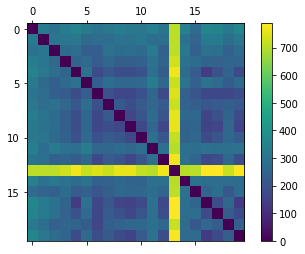

In [91]:
plot_sim(po,30,False)

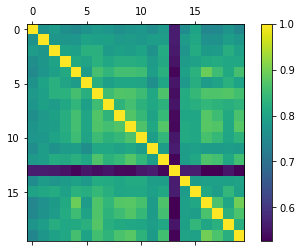

In [141]:
plot_sim(po,35,True)

In [58]:
# #generate xml for all files using srcml
# for outer_d in os.listdir('./DataAnalysis/'):
#     outer_d=os.path.join('./Data',outer_d) #Contest1,2,3,...
#     if os.path.isdir(outer_d):
#         #create dir for xml 
#         xml_dir=os.path.join(outer_d,"all_xml")
#         if not os.path.exists(xml_dir):
#             os.makedirs(xml_dir) 

          
                

In [59]:
path_cpp = '/home/ashish-j/workspace/Data_Analytics/Project/project_local_work/E0259_Project/DataAnalysis/Contest1245/RoW/hm/'
path_xml = '/home/ashish-j/workspace/Data_Analytics/Project/project_local_work/E0259_Project/DataAnalysis/Contest1245/RoW/hm_xml/'

In [55]:
path_cpp = '/home/ashish-j/workspace/Data_Analytics/Project/project_local_work/E0259_Project/DataAnalysis/Contest1245/RoW/lm/'
path_xml = '/home/ashish-j/workspace/Data_Analytics/Project/project_local_work/E0259_Project/DataAnalysis/Contest1245/RoW/lm_xml/'

In [130]:
list_row_lm,f_names_list_row_lm = compute_parse_trees('RoW','lm')
list_row_hm,f_names_list_row_hm = compute_parse_trees('RoW','hm')

In [131]:
list_row = f_names_list_row_lm[:10]+f_names_list_row_hm[:10]

In [132]:
f = open("list_row.txt", "a")
for i in list_row:
    f.write(i+' ')
f.close()

In [133]:
len(list_row)

20

In [145]:
df_0_4_row = pd.read_csv("similarity_matrix_RoW_0_to_4.csv")
df_4_8_row = pd.read_csv("similarity_matrix_RoW_4_to_8.csv")
df_8_12_row = pd.read_csv("similarity_matrix_RoW_8_to_12.csv")
df_12_16_row = pd.read_csv("similarity_matrix_RoW_12_to_16.csv")
df_16_20_row = pd.read_csv("similarity_matrix_RoW_16_to_20.csv")
df_0_4_row.drop('Unnamed: 0',axis=1,inplace=True)
df_4_8_row.drop('Unnamed: 0',axis=1,inplace=True)
df_8_12_row.drop('Unnamed: 0',axis=1,inplace=True)
df_12_16_row.drop('Unnamed: 0',axis=1,inplace=True)
df_16_20_row.drop('Unnamed: 0',axis=1,inplace=True)

In [147]:
po_1 = [df_0_4_row, df_4_8_row, df_8_12_row, df_12_16_row, df_16_20_row]

In [ ]:
po_1 = pd.concat(po_1)
po_1.to_csv("row_combined_similarity.csv")
l1 = np.array(po_1)

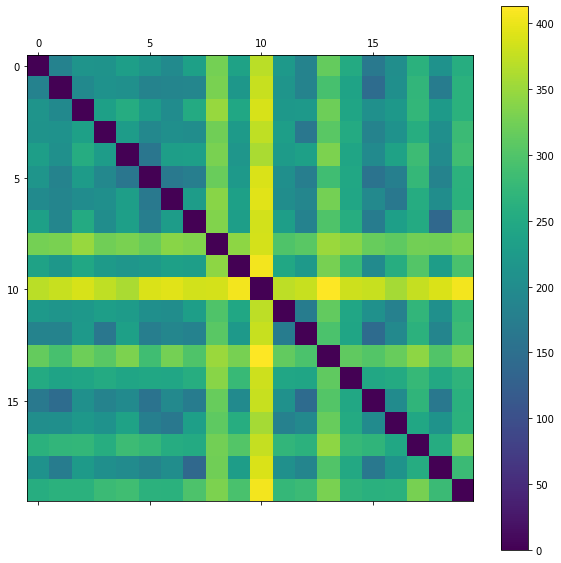

In [163]:
plot_sim(l1,35,False)

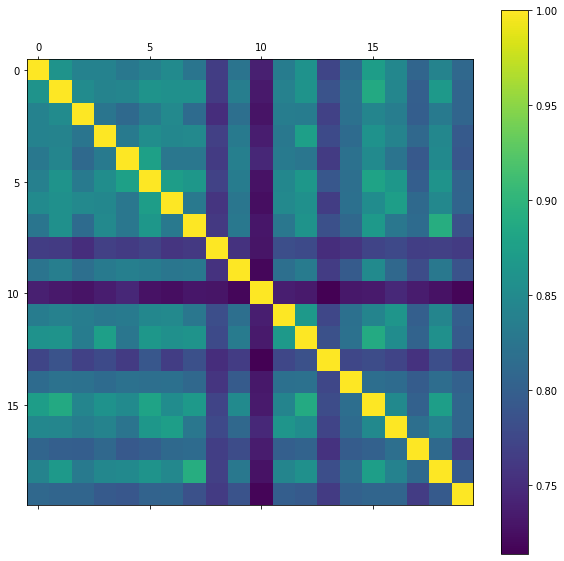

In [164]:
plot_sim(l1,35,True)

In [185]:
list_mix = f_names_list_china_lm[:10]+f_names_list_row_lm[:10]

In [154]:
f = open("list_mix.txt", "a")
for i in list_mix:
    f.write(i+' ')
f.close()

In [155]:
df_0_4_mix = pd.read_csv("similarity_matrix_mix_0_to_4.csv")
df_4_8_mix = pd.read_csv("similarity_matrix_mix_4_to_8.csv")
df_8_12_mix = pd.read_csv("similarity_matrix_mix_8_to_12.csv")
df_12_16_mix = pd.read_csv("similarity_matrix_mix_12_to_16.csv")
df_16_20_mix = pd.read_csv("similarity_matrix_mix_16_to_20.csv")
df_20_24_mix = pd.read_csv("similarity_matrix_mix_20_to_24.csv")
df_24_28_mix = pd.read_csv("similarity_matrix_mix_24_to_28.csv")
df_28_30_mix = pd.read_csv("similarity_matrix_mix_28_to_30.csv")

df_0_4_mix.drop('Unnamed: 0',axis=1,inplace=True)
df_4_8_mix.drop('Unnamed: 0',axis=1,inplace=True)
df_8_12_mix.drop('Unnamed: 0',axis=1,inplace=True)
df_12_16_mix.drop('Unnamed: 0',axis=1,inplace=True)
df_16_20_mix.drop('Unnamed: 0',axis=1,inplace=True)
df_20_24_mix.drop('Unnamed: 0',axis=1,inplace=True)
df_24_28_mix.drop('Unnamed: 0',axis=1,inplace=True)
df_28_30_mix.drop('Unnamed: 0',axis=1,inplace=True)


In [ ]:
po_mix = [df_0_4_mix, df_4_8_mix, df_8_12_mix, df_12_16_mix, df_16_20_mix,df_20_24_mix,df_24_28_mix,df_28_30_mix]
po_mix = pd.concat(po_mix)
po_mix.to_csv("mix_combined_similarity.csv")
l2 = np.array(po_mix)

##  China vs Rest of World Coding Similarity Analysis using Tree edit distance
#### (0-15 Chinese Developers ; 15-30 Rest of World Developers)

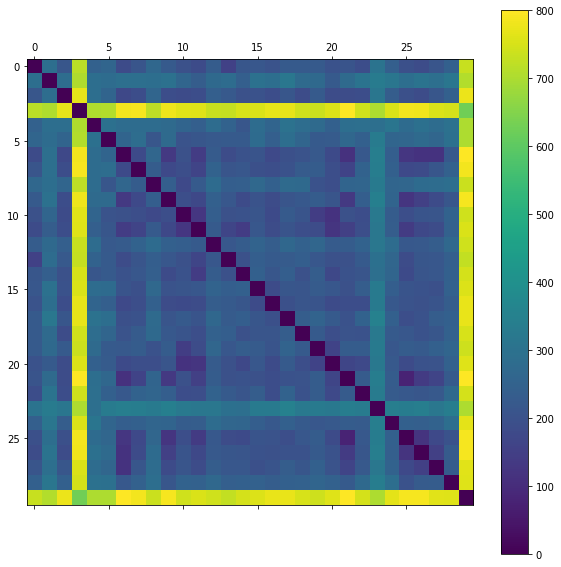

In [162]:
plot_sim(l2,35,False)

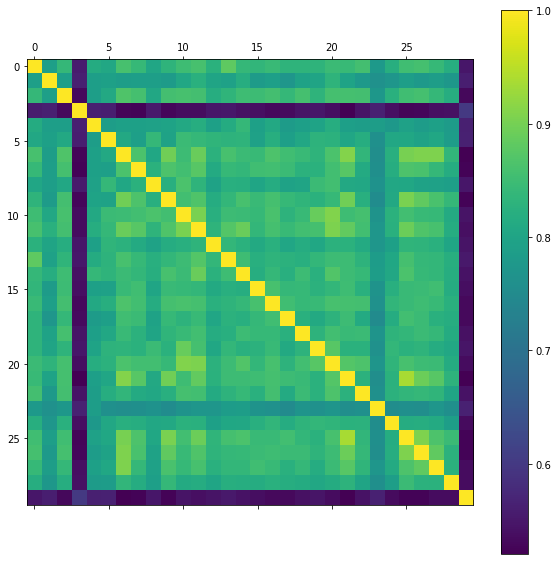

In [161]:
plot_sim(l2,35,True)

## Spectral Clustering Attempt

In [4]:
data = pd.read_csv("mix_combined_similarity.csv")

In [6]:
data.drop('Unnamed: 0',axis=1,inplace=True)

In [10]:
l = (np.array(data))
l_aff = compute_affinity(l,35)

In [14]:
mdl = clustering(l,2)

In [15]:
mdl.labels_

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0])